# <p><center style="font-family:newtimeroman;font-size:180%;"> Generating Anime Faces with DCGAN: A Dataset of High-Quality Anime </center></p>
### Table of contents:

* [Introduction](#1)
* [Import Libraries](#2)
* [Import DataSet](#3)
* [Preprocessing](#4)
* [Create Generator](#5)
* [Create Discriminator](#6)
* [Create Deep Convolutional GAN](#7)
* [Train The Model](#8)
* [Evaluation Of Model Results](#9)

In [1]:
# import requirement libraries and tools
from tensorflow import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv2DTranspose, Reshape, BatchNormalization, Dropout, Input, ReLU, LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Loading and Preparing Anime Face Images Dataset using Keras Image Data Generator
img_width, img_height = 256, 256
batchsize = 32

train = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/animefacedataset',
    batch_size = batchsize,
    image_size = (img_width, img_height))

Found 63565 files belonging to 1 classes.


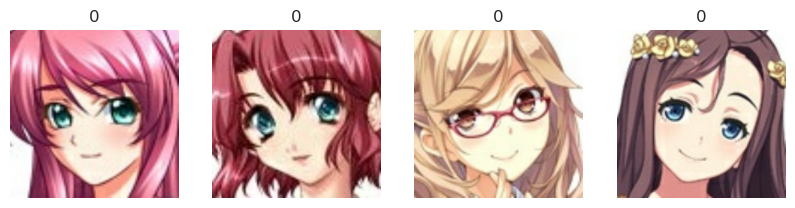

In [12]:
import matplotlib.pyplot as plt

data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    ax[idx].axis('off')  # Remove the axis

plt.show()


In [4]:
# Generating Augmented Batches of Anime Face Images using ImageDataGenerator
DIR = '/kaggle/input/animefacedataset' #path

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
        DIR,
        target_size = (64, 64),
        batch_size = batchsize,
        class_mode = None)

#train_generator[0]

Found 63565 images belonging to 1 classes.


<html>
<head>
</head>
<body>
  <h1> The Generator </h1>
 
</body>
</html>

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             9863168   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 64)       1

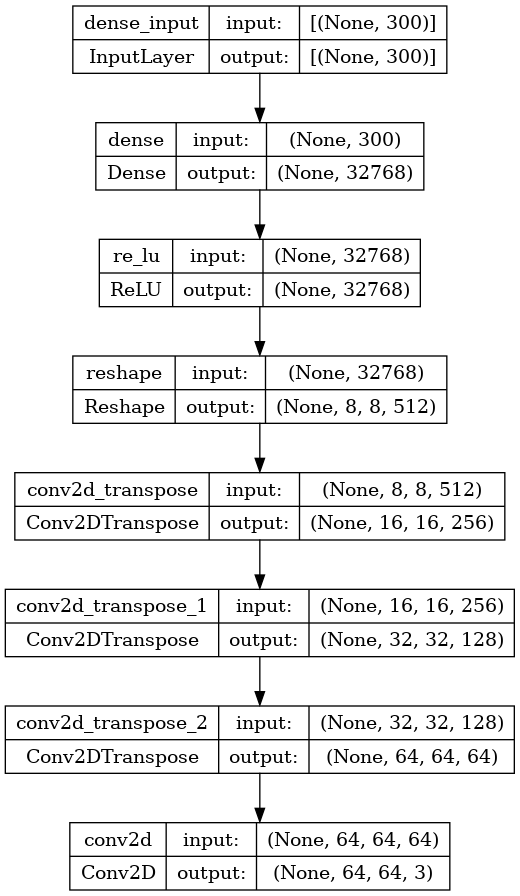

In [5]:
# Creating the Generator Model 

KI = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
input_dim = 300

def Generator_Model():

    Generator = Sequential()

    # Random noise
    Generator.add(Dense(8 * 8 * 512, input_dim = input_dim))
    Generator.add(ReLU())
    # Convert 1d to 3d
    Generator.add(Reshape((8, 8, 512)))
    # Unsample
    Generator.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='ReLU'))
    Generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='ReLU'))
    Generator.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='ReLU'))
    Generator.add(Conv2D(3, (4, 4), padding='same', activation='sigmoid'))

    
    return Generator
    
generator = Generator_Model()
generator.summary()
# Visualized Layers of generator
keras.utils.plot_model(generator, show_shapes=True)

<html>
<head>
</head>
<body>
  <h1> The Discriminator </h1>
  
</body>
</html>

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 256)       

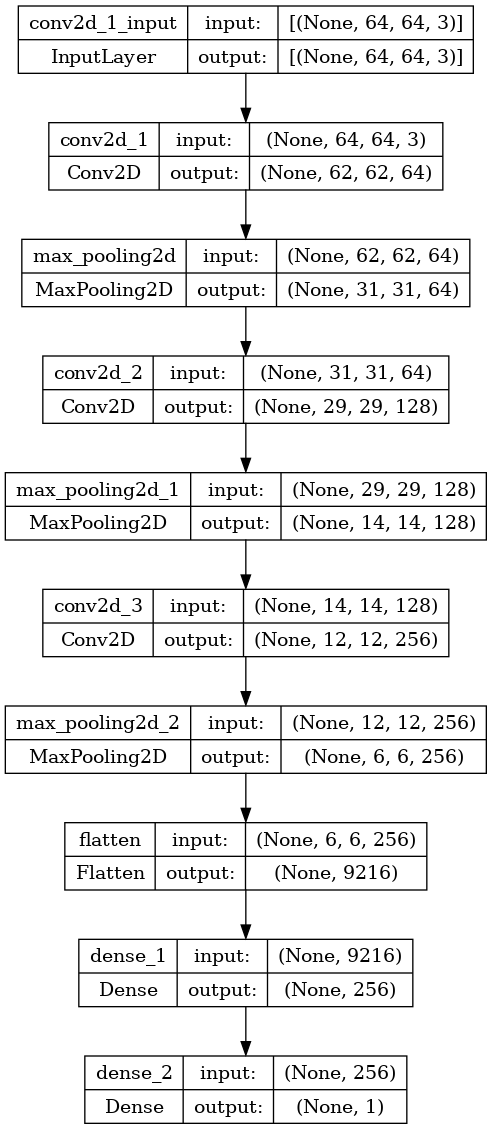

In [6]:
# Creating the discriminator Model 

def Discriminator_Model():
    input_shape = (64, 64, 3)

    # Create a Sequential model
    discriminator = Sequential()
    discriminator.add(Conv2D(64,kernel_size=(3, 3), activation='LeakyReLU', input_shape = input_shape))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Conv2D(128, kernel_size=(3, 3), activation='LeakyReLU'))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Conv2D(256, kernel_size=(3, 3), activation='LeakyReLU'))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Flatten())
    discriminator.add(Dense(256, activation='LeakyReLU'))
    discriminator.add(Dense(1, activation='sigmoid'))

    return discriminator

# Training The CNN
discriminator = Discriminator_Model()
discriminator.summary()  
# Visualized Layers of discriminator
keras.utils.plot_model(discriminator, show_shapes=True)

<html>
<head>
</head>
<body>
  <h1> The Training Process </h1>
 
</body>
</html>



In [7]:
# DCGAN Model Training Step with Discriminator and Generator

class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim = input_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

<html>
<head>
</head>
<body>
  <h1> The Monitoring process </h1>
  
</body>
</html>



In [8]:
# DCGAN Monitor for Image Generation and Model Saving

class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim = input_dim):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs = None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 255) + 255
        g_img.numpy()
        
    def on_train_end(self, logs = None):
        self.model.generator.save('DCGEN.h5')

In [9]:
# Training DCGAN on Image Dataset for 40 Epochs

epochs = 30
lr_g =0.0003
lr_d = 0.0001
beta = 0.5
latent_dim = 300

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim = latent_dim )
dcgan.compile(g_optimizer = Adam (learning_rate= lr_g, beta_1= beta), d_optimizer= Adam (learning_rate = lr_g , beta_1= beta), loss_fn = BinaryCrossentropy())

# Fit the model and save the history
history = dcgan.fit(train_generator, epochs=epochs, callbacks=[DCGANMonitor()])


Epoch 1/30
1987/1987 [==============================] - 580s 285ms/step - d_loss: 0.3793 - g_loss: 2.4168
Epoch 2/30
1987/1987 [==============================] - 157s 79ms/step - d_loss: 0.3762 - g_loss: 2.2936
Epoch 3/30
1987/1987 [==============================] - 156s 79ms/step - d_loss: 0.3567 - g_loss: 2.2549
Epoch 4/30
1987/1987 [==============================] - 189s 95ms/step - d_loss: 0.3170 - g_loss: 2.4931
Epoch 5/30
1987/1987 [==============================] - 241s 121ms/step - d_loss: 0.2816 - g_loss: 2.7004
Epoch 6/30
1987/1987 [==============================] - 232s 117ms/step - d_loss: 0.2732 - g_loss: 2.7905
Epoch 7/30
1987/1987 [==============================] - 179s 90ms/step - d_loss: 0.2539 - g_loss: 2.9290
Epoch 9/30
1144/1987 [================>.............] - ETA: 1:13 - d_loss: 0.2380 - g_loss: 3.0451

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1987/1987 [==============================] - 166s 83ms/step - d_loss: 0.2438 - g_loss: 3.1334
Epoch 12/30
1894/1987 [===========================>..] - ETA: 7s - d_loss: 0.2350 - g_loss: 3.1548

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1987/1987 [==============================] - 176s 89ms/step - d_loss: 0.2185 - g_loss: 3.2658
Epoch 14/30
1987/1987 [==============================] - 247s 124ms/step - d_loss: 0.2032 - g_loss: 3.3545
Epoch 15/30
1987/1987 [==============================] - 170s 86ms/step - d_loss: 0.1902 - g_loss: 3.4754
Epoch 16/30
1987/1987 [==============================] - 166s 84ms/step - d_loss: 0.2046 - g_loss: 3.5007
Epoch 17/30
1987/1987 [==============================] - 174s 87ms/step - d_loss: 0.1997 - g_loss: 3.5789
Epoch 18/30
1987/1987 [==============================] - 165s 83ms/step - d_loss: 0.1725 - g_loss: 3.7782
Epoch 20/30
1776/1987 [=========================>....] - ETA: 18s - d_loss: 0.1496 - g_loss: 3.8492

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1987/1987 [==============================] - 161s 81ms/step - d_loss: 0.1735 - g_loss: 3.9268
Epoch 24/30
1987/1987 [==============================] - 156s 78ms/step - d_loss: 0.0925 - g_loss: 4.1642
Epoch 25/30
 975/1987 [=============>................] - ETA: 1:18 - d_loss: 0.1348 - g_loss: 4.1041

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1987/1987 [==============================] - 154s 77ms/step - d_loss: 0.0890 - g_loss: 4.5123
Epoch 29/30
1987/1987 [==============================] - 154s 77ms/step - d_loss: 0.0667 - g_loss: 4.5452
Epoch 30/30
 154/1987 [=>............................] - ETA: 2:21 - d_loss: -0.1216 - g_loss: 4.8697

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



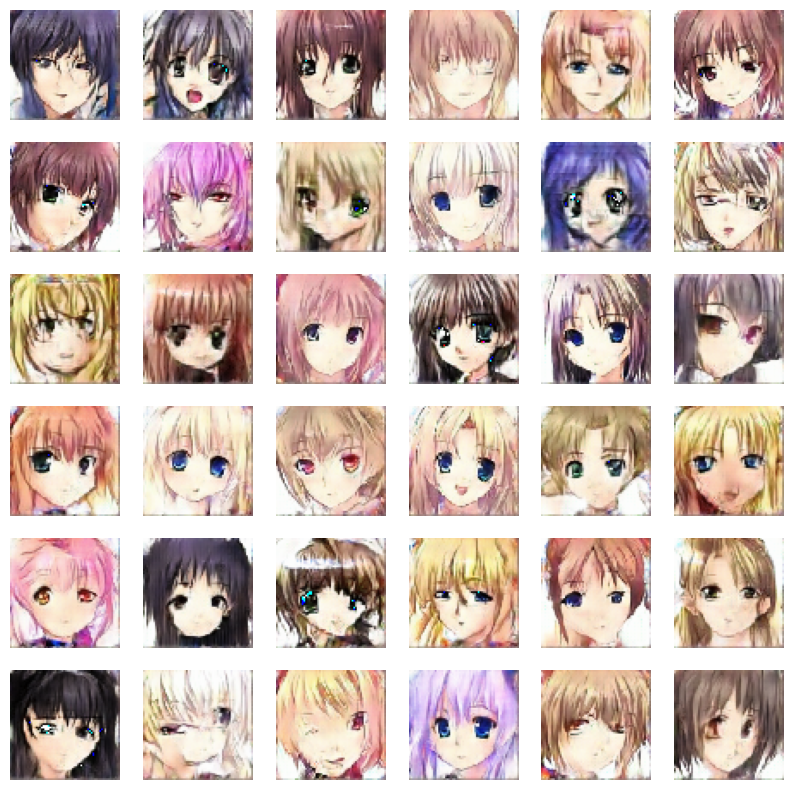

In [10]:
# Generating 36 Random Images with DCGAN

plt.figure(figsize=(10, 10))

for i in range(36):
    plt.subplot(6, 6, i + 1)
    # Generate random noise for each image
    noise = tf.random.normal([1, 300])
    mg = dcgan.generator(noise)
    # Denormalize
    mg = (mg * 255) + 255

    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))

    plt.imshow(image)
    plt.axis('off')

plt.show()

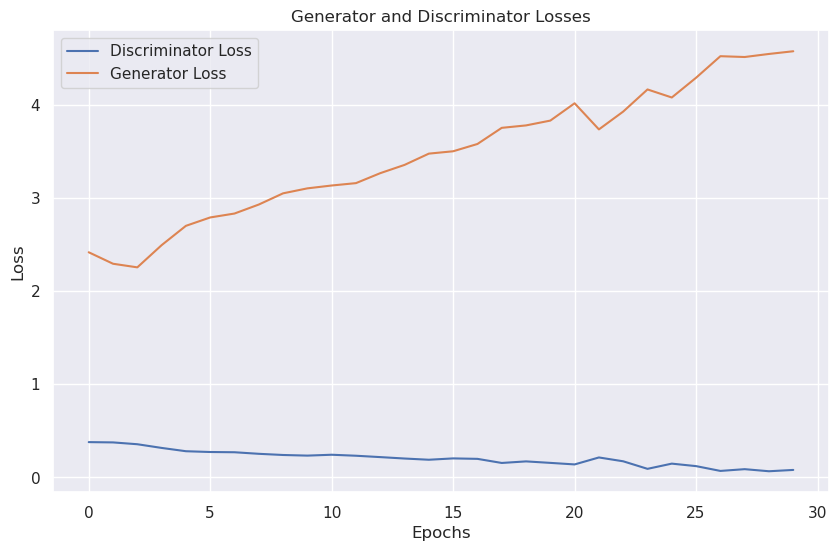

In [11]:
import matplotlib.pyplot as plt

# Function to create a figure for the losses
def create_loss_figure(d_loss_values, g_loss_values):
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss_values, label='Discriminator Loss')
    plt.plot(g_loss_values, label='Generator Loss')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Access the loss values from the history
d_loss_values = history.history['d_loss']
g_loss_values = history.history['g_loss']

# Call the create_loss_figure function with the loss values
create_loss_figure(d_loss_values, g_loss_values)